# Problema 2


En el siguiente problema, se presenta un conjunto de datos correspondientes a escritos de Shakespear. El objetivo del problema es crear un modelo capaz de generar texto con dialecto de época y escritura en verso y prosa.


Dataset:
https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

El dataset proporcionado incluye 40000 líneas de distintos escritos de Shakespear. Sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.


## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

Importar librerías

In [ ]:
!pip install --q tensorflow==2.15.1

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Leer la data

Primero, miremos el texto:

In [ ]:
"""

https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

El dataset proporcionado incluye 40000 líneas de distintos escritos de Shakespear.

Sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.

"""

import requests

# URL del archivo de texto de Shakespeare
url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verifica que la solicitud fue exitosa
if response.status_code == 200:
    # Guarda el contenido en un archivo local
    with open("shakespeare.txt", "wb") as file:
        file.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo. Código de estado:", response.status_code)


Archivo descargado exitosamente.


In [ ]:
# Read, then decode for py2 compat.
text = open("/content/shakespeare.txt", 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# Modelo caracter a caracter

## Preprocesamiento

### Vectorizacion del texto

Previo al entrenamiento, necesitamos convertir el texto a una representacion numerica.

La capa `tf.keras.layers.StringLookup` nos permite convertir cada caracter en un ID numerico. Solo necesita que el texto este separado primero en tokens.

In [ ]:
chars = tf.strings.unicode_split(vocab, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'\n'],
 [b' '],
 [b'!'],
 [b'$'],
 [b'&'],
 [b"'"],
 [b','],
 [b'-'],
 [b'.'],
 [b'3'],
 [b':'],
 [b';'],
 [b'?'],
 [b'A'],
 [b'B'],
 [b'C'],
 [b'D'],
 [b'E'],
 [b'F'],
 [b'G'],
 [b'H'],
 [b'I'],
 [b'J'],
 [b'K'],
 [b'L'],
 [b'M'],
 [b'N'],
 [b'O'],
 [b'P'],
 [b'Q'],
 [b'R'],
 [b'S'],
 [b'T'],
 [b'U'],
 [b'V'],
 [b'W'],
 [b'X'],
 [b'Y'],
 [b'Z'],
 [b'a'],
 [b'b'],
 [b'c'],
 [b'd'],
 [b'e'],
 [b'f'],
 [b'g'],
 [b'h'],
 [b'i'],
 [b'j'],
 [b'k'],
 [b'l'],
 [b'm'],
 [b'n'],
 [b'o'],
 [b'p'],
 [b'q'],
 [b'r'],
 [b's'],
 [b't'],
 [b'u'],
 [b'v'],
 [b'w'],
 [b'x'],
 [b'y'],
 [b'z']]>

Ahora creamos la capa `tf.keras.layers.StringLookup`:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

Esto nos convierte de tokens a IDs de caracteres:

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65]]>

Importante invertir esta representacion y recuperar texto legible desde estos IDs. Para esto podemos usar `tf.keras.layers.StringLookup(..., invert=True)`.

Nota: Aquí, en lugar de pasar el vocabulario original generado con `sorted(set(text))`, usamos el método `get_vocabulary()` de la capa `tf.keras.layers.StringLookup` para que los tokens `[UNK]` se configuren de la misma manera.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Esta capa recupera los caracteres desde los vectores de IDs y los retorna como un `tf.RaggedTensor` de caracteres:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'\n'],
 [b' '],
 [b'!'],
 [b'$'],
 [b'&'],
 [b"'"],
 [b','],
 [b'-'],
 [b'.'],
 [b'3'],
 [b':'],
 [b';'],
 [b'?'],
 [b'A'],
 [b'B'],
 [b'C'],
 [b'D'],
 [b'E'],
 [b'F'],
 [b'G'],
 [b'H'],
 [b'I'],
 [b'J'],
 [b'K'],
 [b'L'],
 [b'M'],
 [b'N'],
 [b'O'],
 [b'P'],
 [b'Q'],
 [b'R'],
 [b'S'],
 [b'T'],
 [b'U'],
 [b'V'],
 [b'W'],
 [b'X'],
 [b'Y'],
 [b'Z'],
 [b'a'],
 [b'b'],
 [b'c'],
 [b'd'],
 [b'e'],
 [b'f'],
 [b'g'],
 [b'h'],
 [b'i'],
 [b'j'],
 [b'k'],
 [b'l'],
 [b'm'],
 [b'n'],
 [b'o'],
 [b'p'],
 [b'q'],
 [b'r'],
 [b's'],
 [b't'],
 [b'u'],
 [b'v'],
 [b'w'],
 [b'x'],
 [b'y'],
 [b'z']]>

Finalmente usando `tf.strings.reduce_join` se pueden volver a juntar los caracteres en texto.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'\n', b' ', b'!', b'$', b'&', b"'", b',', b'-', b'.', b'3', b':',
       b';', b'?', b'A', b'B', b'C', b'D', b'E', b'F', b'G', b'H', b'I',
       b'J', b'K', b'L', b'M', b'N', b'O', b'P', b'Q', b'R', b'S', b'T',
       b'U', b'V', b'W', b'X', b'Y', b'Z', b'a', b'b', b'c', b'd', b'e',
       b'f', b'g', b'h', b'i', b'j', b'k', b'l', b'm', b'n', b'o', b'p',
       b'q', b'r', b's', b't', b'u', b'v', b'w', b'x', b'y', b'z'],
      dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Visualización de los datos

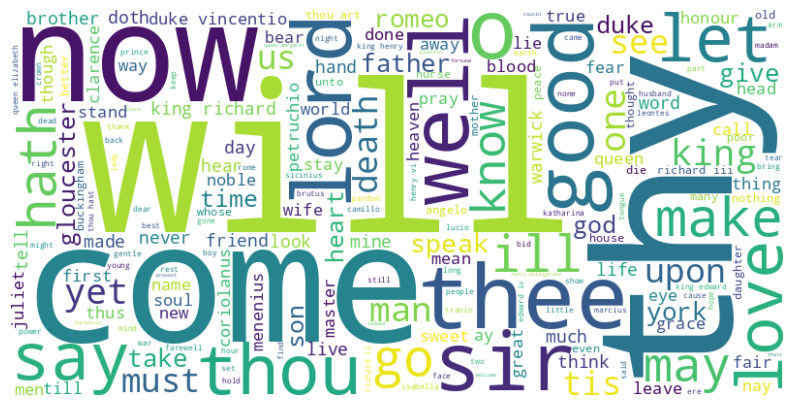

In [ ]:
    # Limpiar el texto (eliminar caracteres no alfabéticos)
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Crear la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Prediccion

Dado un caracter, o una secuencia de caracteres, ¿cuál es el siguiente caracter más probable? Esta es la tarea para la que estamos entrenando al modelo. La entrada al modelo será una secuencia de caracteres y entrenamos el modelo para predecir la salida: el siguiente carácter en cada paso de tiempo.

Dado que los RNN mantienen un estado interno que depende de los elementos vistos anteriormente, a partir de todos los caracteres calculados hasta este momento, ¿cuál es el siguiente carácter?

### Crear los ejemplos de entrenamiento

Dividimos el texto en secuencias de ejemplo. Cada secuencia de entrada contendrá `seq_length` caracteres del texto.

Para cada secuencia de entrada, los targets correspondientes contienen la misma longitud de texto, excepto que se desplazan un carácter hacia la derecha.

Así que divida el texto en fragmentos de `seq_length+1`. Por ejemplo, digamos que `seq_length` es 3 y nuestro texto es "Hola". La secuencia de entrada sería "Hol" y la secuencia target "ola".

Para hacer esto, usamos la función `tf.data.Dataset.from_tensor_slices` para convertir el vector de texto en una secuencia de índices de caracteres.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

El método `batch` nos permite convertir fácilmente estos caracteres individuales en secuencias del tamaño deseado.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


Es mas facil ver lo que esta haciendo si unimos de vuelta los tokens en texto:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Para el entrenamiento, necesitaremos un conjunto de datos de pares `(input, label)`. Donde `input` y
`label` son secuencias. En cada timestep, la entrada es el carácter actual y la etiqueta es el siguiente carácter.

Aquí hay una función que toma una secuencia como entrada, la duplica y la desplaza para alinear la entrada y la etiqueta para cada timestep:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Batches de entrenamiento

Usamos `tf.data` para dividir el texto en secuencias manejables. Pero antes de introducir estos datos en el modelo, es necesario mezclarlos y batchearlos.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Construccion del modelo

En esta sección definimos el modelo como una subclase de `keras.Model`
Este modelo tiene tres capas:

* `tf.keras.layers.Embedding`: La capa de entrada. Una lookup table entrenable que asignará cada ID de carácter a un vector con dimensiones `embedding_dim`;
* `tf.keras.layers.GRU`: una capa recurrente GRU de tamaño `units=rnn_units` (también se puede usar una capa LSTM aquí).
* `tf.keras.layers.Dense`: La capa de salida, con salidas `vocab_size`. Genera un logit para cada carácter del vocabulario. Estas son las probabilidades de cada caracter según el modelo.

In [ ]:
import tensorflow as tf

# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Por cada caracter el modelo calcula su embedding, corre la GRU un timestep con el embedding como entrada y aplica la capa densa para generar los logits prediciendo la probabilidades del siguiente caracter.

![A drawing of the data passing through the model](https://github.com/FCEIA-AAII/lab10/blob/master/images/text_generation_training.png?raw=1)

Nota: Para el entrenamiento, se puede utilizar un modelo `keras.Sequential`. Para generar texto más adelante, necesitaremos administrar el estado interno de la RNN. Es más sencillo incluir las opciones de entrada y salida de estado por adelantado que reorganizar la arquitectura del modelo más adelante. Para obtener más detalles, consulte [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


En el ejemplo anterior, la longitud de la secuencia de la entrada es `100`, pero el modelo se puede ejecutar con entradas de cualquier longitud:

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Para obtener predicciones reales del modelo, se deben tomar muestras de la distribución de salida para obtener índices de caracteres reales. Esta distribución está definida por los logits sobre el vocabulario de los caracteres.

Nota: Es importante tomar una muestra de esta distribución, ya que tomar el _argmax_ de la distribución puede fácilmente hacer que el modelo se atasque en un bucle.

Tomando como ejemplo el primero del batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Esto nos da para cada timestep una predicción del siguiente índice de caracteres:

In [ ]:
sampled_indices

array([19, 50, 14, 33, 47, 14, 14, 12, 14,  6, 61, 21, 45, 61, 28, 44, 64,
       25, 37, 29, 57, 25, 18, 25, 60, 53, 10, 64, 34, 12, 28,  9,  1, 56,
       18, 47,  9, 55, 22,  0, 42, 54, 51, 54, 30, 13, 61, 51,  4, 65, 33,
        8, 28, 40,  9, 49,  4, 62, 31, 20, 16, 31, 11,  5, 46, 35, 61, 51,
       44, 59, 46, 38, 39, 20, 65, 58, 45, 53, 33, 44,  7, 16, 27, 54, 24,
       54, 23, 11, 63, 10,  6, 13, 34, 47, 16, 22, 10, 18,  4, 13])

Por ultimo los decodificamos para ver el texto predicho por este modelo no entrenado:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ther die by the law than my son should be\nunlawfully born. But, O, how much is the good duke\ndeceive'

Next Char Predictions:
 b"FkAThAA;A'vHfvOeyLXPrLELun3yU;O.\nqEh.pI[UNK]coloQ?vl$zT-Oa.j$wRGCR:&gVvletgYZGzsfnTe,CNoKoJ:x3'?UhCI3E$?"


## Entrenamiento del modelo

El problema puede tratarse como un problema de clasificación estándar. Dado el estado RNN anterior y la entrada en este timestep, predice la clase del siguiente carácter.

### Agregamos un optimizador y una funcion costo

La función de pérdida estándar `tf.keras.losses.sparse_categorical_crossentropy` funciona en este caso porque se aplica en la última dimensión de las predicciones.

Debido a que su modelo devuelve logits, necesita configurar el indicador `from_logits`.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190506, shape=(), dtype=float32)


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo, todos los logits de salida deberían tener magnitudes similares. Para confirmar esto, puede comprobar que la exponencial del costo medio es aproximadamente igual al tamaño del vocabulario. Una pérdida mucho mayor significa que el modelo está seguro de sus respuestas incorrectas y está mal inicializado:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.056206

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Checkpoints del modelo

Usamos el callback `tf.keras.callbacks.ModelCheckpoint` para que se guarden checkpoints del modelo durante el entrenamiento.

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Ejecucion del entrenamiento

Para mantener un tiempo de entrenamiento razonable, utilice entre 10 y 20 épocas para entrenar el modelo. En Colab, configure el tiempo de ejecución en GPU para un entrenamiento más rápido.

In [ ]:
EPOCHS = 50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
172/172 [==============================] - 16s 61ms/step - loss: 2.7128
Epoch 2/50
172/172 [==============================] - 10s 51ms/step - loss: 1.9823
Epoch 3/50
172/172 [==============================] - 10s 52ms/step - loss: 1.7013
Epoch 4/50
172/172 [==============================] - 12s 52ms/step - loss: 1.5413
Epoch 5/50
172/172 [==============================] - 11s 52ms/step - loss: 1.4445
Epoch 6/50
172/172 [==============================] - 10s 51ms/step - loss: 1.3770
Epoch 7/50
172/172 [==============================] - 11s 52ms/step - loss: 1.3250
Epoch 8/50
172/172 [==============================] - 11s 51ms/step - loss: 1.2789
Epoch 9/50
172/172 [==============================] - 12s 52ms/step - loss: 1.2376
Epoch 10/50
172/172 [==============================] - 11s 52ms/step - loss: 1.1969
Epoch 11/50
172/172 [==============================] - 11s 53ms/step - loss: 1.1572
Epoch 12/50
172/172 [==============================] - 11s 53ms/step - loss: 1.1138
E

## Generacion de texto

La forma más sencilla de generar texto con este modelo es ejecutarlo en un bucle y realizar un seguimiento del estado interno del modelo a medida que lo ejecutamos.

![Para generar texto, la salida del modelo se retroalimenta a la entrada](https://github.com/FCEIA-AAII/lab10/blob/master/images/text_generation_sampling.png?raw=1)

Cada vez que llamamos al modelo, pasamos algún texto y un estado interno. El modelo devuelve una predicción para el siguiente caracter y su nuevo estado. Vuelva a pasar la predicción y el estado para continuar generando texto.


Lo siguiente hace una predicción de un solo paso:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Lo ejecutamos en un bucle para generar texto. Al observar el texto generado, veremos que el modelo sabe cuándo poner mayúsculas, hacer párrafos e imita un vocabulario de escritura similar al de Game Of Thrones. Con el reducido número de épocas de entrenamiento, todavía no ha aprendido a formar frases coherentes.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Sheakspeare'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Sheakspeares notive but boundly lists
And pluck'd up with procereings, that no more comes
To have some part end or solemn hands.

CLIFFORD:
My lady's dead! how he is in!
Here comes the fault to you. Lord Angelo's womb,
That rage, for quarrel of a soldier arm;
Hold-morrow, as I am now chaste, and Tranio.

TRANIO:
Master, fool! what, in this viewly die?

DUKE OF YORK:
Please you, sir, so hath a haste hours here let God his grace.
A pack had more blazing incornatement
Of my heart's deputy, shall kingly give thee like requian.

KING RICHARD II:
Now put it, I say; thou shouldst be man,
Like out again with rude and lent mischance
In the shepherd's nose, and let the coronation.
Thy father, by God-grandon! Who's there? O woful, we have spoke,
a bawd of health, and give him chair, and shrift
His horse in blood, but in my speeches
Were neared to: for a thousand crowns!
I prophys are made to be his dishonour'd,--
Whom Warwick was my father's fault, if this Marcius
Where were unearded! make not ma

Lo más fácil que podemos hacer para mejorar los resultados es entrenarlo por más tiempo (prueba con `EPOCHS = 30`).

También puede experimentar con una secuencia de inicio diferente, intentar agregar otra capa RNN para mejorar la precisión del modelo o ajustar el parámetro de temperatura para generar predicciones más o menos aleatorias.

Si queremos que el modelo genere texto *más rápido*, lo más fácil que se puede hacer es generar el texto por batches. En el siguiente ejemplo, el modelo genera 5 resultados aproximadamente en el mismo tiempo que tomó generar 1 arriba.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Sheakspeare', 'Sheakspeare', 'Sheakspeare', 'Sheakspeare', 'Sheakspeare'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"Sheakspeares night, thy love! that when the son is\ntent me, now for our eyes do harm he himself\nUpon this doing and ruterly dancing;\nFor the endeards of your five house of his country:\nIt is Lord Angelo.\n\nProvost:\nA brant is your office.\n\nPETRUCHIO:\nWhat, upares your hand!\n\nHORTENSIO:\nFaith, he is growing of the hatrest, that would\nBecome such a person. that if as\nam not respite'sture. This froth case sighs as\nyou shall lie night can humbly other light:\nBut to refuse your highness; I'll assure you\nOf some mercy: if I may have no more strange?\n\nQUEEN ELIZABETH:\nCome, my Lord of Buckingham: but a not falch from her king,\nAs I can first the helm of yours,\nLet it be not too too found him; he is as little\nWorse that blows us all the chaftimoor\nMake raken unroon and a sudden audy too.\n\nTYBALT:\nKind upon you!\n\nABHORSON:\nTruly, justice! This poor masters do,\nI am a hundred mortal sting: and see the wreck.\nThis is a man, old, wrinkled, faded.\nNow,

#### Probar con distintas temperaturas

In [ ]:
temperatures = [0.5, 1.0, 1.5]
results = []

for temp in temperatures:
    print(f"\n### Generando texto con temperatura: {temp} ###\n")
    one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=temp)

    states = None
    next_char = tf.constant(['Sheakspeare'])
    result = [next_char]

    for n in range(300):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)

    result = tf.strings.join(result)
    print(result[0].numpy().decode('utf-8'))



### Generando texto con temperatura: 0.5 ###

Sheakspeares notice, how his happier kind
That breed by the immodable of your brother's part,
And, by the stranger pluck in hope, which will in time
Break ope the devil and deliver you
Of some short of my steed, whose tender lady
Hath set the birds of patience and in one army
Beggars, and gave them for the fau

### Generando texto con temperatura: 1.0 ###

Sheakspeares notice of his hands and that to the
out: mine honest cheek the man, that thou art old,
which now you seem'd ladies with a horse-frought of
instered.

Second Citizen:
What will mourn fight, and yet my brother's blood,
He's base the fearful King of France:
Let us be blessed new together, but thou
ca

### Generando texto con temperatura: 1.5 ###

Sheakspeares notice of Venician grave?

DUCHESS OF YORK:
Nay, if thy time would follow me.

GLOUCESTER:
Come you, pray, let us hear these years
a most hell; and such in justice, yield,
My soil thou art, an envious that I have.

RICHARD

# Modelo Palabra a Palabra

### Preprocesamiento para palabra a palabra

### Descripción del Código

Este fragmento de código implementa el proceso de tokenización de texto a nivel de palabras utilizando TensorFlow, específicamente con la clase `Tokenizer` de Keras. A continuación se desglosa el funcionamiento de cada parte:

1. **Creación del Tokenizer**:  
   Se inicializa un tokenizador de texto de Keras con los siguientes parámetros:
   - `filters=''`: No se aplican filtros sobre los caracteres especiales, lo que significa que los signos de puntuación y otros caracteres no serán eliminados.
   - `lower=False`: Los textos no serán convertidos a minúsculas, lo que preserva la distinción entre mayúsculas y minúsculas en el texto.

2. **Ajuste del Tokenizer**:  
   Se entrena el tokenizador en el texto proporcionado (almacenado en la variable `text`). El método `fit_on_texts` analiza el texto y construye un índice de palabras basado en la frecuencia de aparición de cada una.

3. **Creación de los Diccionarios `word2idx` e `idx2word`**:  
   - `word2idx`: Es un diccionario que mapea cada palabra del vocabulario a un índice único.
   - `idx2word`: Es el diccionario inverso, donde cada índice se asocia a su palabra correspondiente.

4. **Conversión de Texto a Índices**:  
   Este paso convierte el texto en una secuencia de enteros, donde cada entero corresponde al índice de la palabra en el vocabulario generado por el tokenizador. El resultado es una lista de índices que representan el texto.

5. **Obtención del Tamaño del Vocabulario**:  
   Calcula el tamaño total del vocabulario, es decir, el número de palabras únicas presentes en el texto.

6. **Impresión del Tamaño del Vocabulario**:  
   Finalmente, se imprime el tamaño del vocabulario a nivel de palabras, proporcionando información clave sobre la cantidad de términos únicos procesados por el tokenizador.

---

Este código permite transformar un texto en una representación numérica, donde cada palabra es sustituida por su índice correspondiente, lo cual es útil para su posterior procesamiento en modelos de aprendizaje automático, como redes neuronales para tareas de procesamiento de lenguaje natural (PLN).


In [ ]:
# Tokenizar a nivel de palabras
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False)
tokenizer.fit_on_texts([text])
word2idx = tokenizer.word_index
idx2word = {idx: word for word, idx in word2idx.items()}

# Convertir texto a índices
text_as_word_int = tokenizer.texts_to_sequences([text])[0]
vocab_size_word = len(word2idx)

print(f"Vocabulario a nivel de palabras: {vocab_size_word}")


Vocabulario a nivel de palabras: 42196


### Crear el dataset

###### Descripción del Código

Este bloque de código tiene como objetivo crear y entrenar un modelo de red neuronal para procesamiento de lenguaje natural utilizando un enfoque basado en RNN (Redes Neuronales Recurrentes). A continuación se detallan sus componentes clave:

1. **Definición de Longitud de Secuencia**:  
   Se establece la longitud de las secuencias de entrada (`seq_length_word = 20`), lo que significa que el modelo tomará ventanas de 20 palabras consecutivas para entrenar. Luego, el texto se convierte en un conjunto de secuencias de longitud fija mediante el uso de `tf.data.Dataset`.

2. **División en Entrada y Salida**:  
   La función `split_input_target_word` toma un fragmento de texto (una secuencia) y lo divide en dos partes:
   - **Entrada**: Todos los elementos de la secuencia, excepto el último (`chunk[:-1]`).
   - **Salida**: Todos los elementos de la secuencia, excepto el primero (`chunk[1:]`).
   Estas secuencias se utilizan como pares de entrada y salida para el entrenamiento del modelo.

3. **Configuración de Batches**:  
   Se configuran el tamaño de los lotes (`BATCH_SIZE = 64`) y un buffer para el shuffling de los datos (`BUFFER_SIZE = 10000`), lo que asegura que el modelo reciba datos aleatorios en cada época. El método `shuffle()` garantiza que los datos no sigan un patrón predecible.

4. **Parámetros del Modelo**:  
   - `embedding_dim_word = 256`: Dimensionalidad de los vectores de palabras en el espacio de características.
   - `rnn_units_word = 1024`: Número de unidades en la capa recurrente, lo que determina la capacidad del modelo para capturar dependencias a largo plazo.

5. **Instanciación del Modelo**:  
   El modelo es instanciado con la clase personalizada `MyModel`, que toma como parámetros:
   - `vocab_size_word + 1`: El tamaño del vocabulario más 1 (para incluir el token de relleno).
   - `embedding_dim_word`: La dimensión del espacio de embedding.
   - `rnn_units_word`: El número de unidades en la capa recurrente.

6. **Compilación y Entrenamiento del Modelo**:  
   - **Compilación**: El modelo es compilado con el optimizador `Adam` y una función de pérdida predefinida.
   - **Entrenamiento**: El modelo se entrena durante 45 épocas usando el conjunto de datos creado anteriormente. Durante este proceso, se muestra la pérdida por cada época, que debe disminuir a medida que el modelo aprende a predecir correctamente las secuencias de texto.

7. **Resumen del Modelo**:  
   Al finalizar el entrenamiento, se muestra un resumen del modelo (`word_model.summary()`), proporcionando detalles sobre las capas y los parámetros entrenables del modelo.

---

Este enfoque de tokenización y modelado con redes neuronales recurrentes permite la creación de modelos avanzados de predicción de texto, capaces de aprender dependencias temporales y generar o completar secuencias de palabras de manera coherente.


In [ ]:
# Definir longitud de secuencia
seq_length_word = 20
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_word_int)
sequences_word = word_dataset.batch(seq_length_word + 1, drop_remainder=True)

# Dividir en entrada y salida
def split_input_target_word(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

word_dataset = sequences_word.map(split_input_target_word)


In [ ]:
# Configurar batches
BATCH_SIZE = 64
BUFFER_SIZE = 10000

word_dataset = word_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
# Parámetros del modelo
embedding_dim_word = 256
rnn_units_word = 1024

# Instanciar el modelo
word_model = MyModel(vocab_size_word + 1, embedding_dim_word, rnn_units_word)

# Compilación y entrenamiento
word_model.compile(optimizer='adam', loss=loss)
word_model.fit(word_dataset, epochs=45)


Epoch 1/45
126/126 [==============================] - 23s 139ms/step - loss: 9.2425
Epoch 2/45
126/126 [==============================] - 16s 125ms/step - loss: 8.2626
Epoch 3/45
126/126 [==============================] - 16s 121ms/step - loss: 8.0761
Epoch 4/45
126/126 [==============================] - 16s 124ms/step - loss: 7.8710
Epoch 5/45
126/126 [==============================] - 16s 121ms/step - loss: 7.6029
Epoch 6/45
126/126 [==============================] - 16s 123ms/step - loss: 7.2919
Epoch 7/45
126/126 [==============================] - 16s 123ms/step - loss: 6.8961
Epoch 8/45
126/126 [==============================] - 16s 122ms/step - loss: 6.3637
Epoch 9/45
126/126 [==============================] - 16s 121ms/step - loss: 5.7168
Epoch 10/45
126/126 [==============================] - 16s 122ms/step - loss: 4.9689
Epoch 11/45
126/126 [==============================] - 16s 122ms/step - loss: 4.1694
Epoch 12/45
126/126 [==============================] - 16s 122ms/step - lo

In [ ]:
word_model.summary()

Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  10802432  
                                                                 
 gru_3 (GRU)                 multiple                  3938304   
                                                                 
 dense_3 (Dense)             multiple                  43251925  
                                                                 
Total params: 57992661 (221.22 MB)
Trainable params: 57992661 (221.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Generación de texto palabra a palabra

###### Descripción del Código

Este fragmento de código implementa la generación de texto a partir de un modelo entrenado utilizando la clase `OneStepWord`, que permite generar palabras de manera secuencial en función de las predicciones del modelo. A continuación se explica cada una de las partes clave:

1. **Clase `OneStepWord`**:  
   La clase `OneStepWord` hereda de `tf.keras.Model` y está diseñada para realizar la predicción paso a paso (una palabra a la vez) en un modelo de lenguaje basado en redes neuronales. En su inicialización, se pasan varios parámetros, entre ellos el modelo preentrenado, el diccionario de mapeo de palabras a índices (`word2idx`), el diccionario inverso de índices a palabras (`idx2word`), y una temperatura de control (`temperature`).

   - **Máscara de Predicción**:  
     Se crea una máscara para evitar la predicción de la palabra "[UNK]" (desconocida) durante la generación. Esto se logra al asignar un valor `-inf` a los índices correspondientes a "[UNK]", lo que hace que nunca se seleccione esa palabra durante el proceso de muestreo.

   - **Tabla de Búsqueda (StaticHashTable)**:  
     Se utiliza una `StaticHashTable` de TensorFlow para mapear las palabras a índices de manera eficiente durante la generación.

2. **Método `generate_one_step`**:  
   Este método genera una palabra a partir de una secuencia de entrada, paso a paso:
   - **Entrada de Texto**:  
     El texto de entrada se convierte a índices utilizando la tabla de búsqueda `lookup_table`.
   - **Generación de Predicción**:  
     El modelo realiza una predicción de los logits (probabilidades sin normalizar) para cada palabra en la secuencia. Los logits son ajustados dividiéndolos por la temperatura para controlar la "creatividad" o "variabilidad" en la generación. A continuación, se aplica la máscara para evitar la palabra "[UNK]".
   - **Muestreo**:  
     Los logits ajustados se utilizan para realizar el muestreo de la siguiente palabra mediante `tf.random.categorical()`, seleccionando el índice con mayor probabilidad (o uno aleatorio si la temperatura es alta).
   - **Conversión de Índices a Palabras**:  
     Los índices generados se convierten nuevamente a palabras utilizando el diccionario `idx2word`.

3. **Generación de Texto con Diferentes Temperaturas**:  
   Se generan textos utilizando tres valores diferentes de temperatura (`0.5`, `1.0`, y `1.5`).  
   - **Temperatura Baja (0.5)**: Generará texto más predecible y coherente, ya que reduce la aleatoriedad en la selección de palabras.
   - **Temperatura Media (1.0)**: Es el comportamiento "neutral", balanceando coherencia y creatividad.
   - **Temperatura Alta (1.5)**: Introducirá mayor variabilidad y puede generar texto más inesperado y creativo, pero potencialmente incoherente.

4. **Proceso de Generación**:  
   - Se inicializa la secuencia de inicio con el texto `'To be or not to be'`.
   - En cada iteración, se genera una palabra nueva utilizando el modelo, añadiéndola al resultado hasta alcanzar un total de 100 palabras.
   - El texto generado se une y se imprime.

---

Este enfoque de generación de texto paso a paso permite crear salidas coherentes y controladas, con la posibilidad de ajustar la creatividad mediante la temperatura, lo que puede ser útil en aplicaciones de procesamiento de lenguaje natural como la generación automática de texto o la creación de contenido.


In [ ]:
class OneStepWord(tf.keras.Model):
    def __init__(self, model, word2idx, idx2word, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.word2idx = word2idx
        self.idx2word = idx2word

        # Crear una máscara para evitar la palabra "[UNK]" de ser generada.
        skip_ids = tf.constant([self.word2idx.get('[UNK]', 0)], dtype=tf.int64)[:, None]
        sparse_mask = tf.SparseTensor(
            # Colocar -inf en cada índice que no sea válido.
            values=[-float('inf')] * len(skip_ids),
            indices=skip_ids,
            dense_shape=[len(word2idx)])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

        # Convertir idx2word a un tensor de strings
        self.idx2word_tensor = tf.constant(list(self.idx2word.values()), dtype=tf.string)

        # Crear un StaticHashTable para mapeo de palabra a índice
        keys = list(self.word2idx.keys())
        values = list(self.word2idx.values())
        self.lookup_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(keys, dtype=tf.string),
                values=tf.constant(values, dtype=tf.int64)
            ), default_value=self.word2idx.get('[UNK]', 0)
        )

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convertir las palabras a IDs de tokens utilizando el hash table
        input_words = tf.strings.split(inputs)
        input_ids = self.lookup_table.lookup(input_words)

        # Asegurarse de que los inputs estén en la forma adecuada (batch_size, sequence_length)
        input_ids = tf.expand_dims(input_ids, axis=0)  # Hacer que la dimensión del batch sea 1
        input_ids = tf.reshape(input_ids, (1, -1))  # Aplanar los inputs en una secuencia

        # Ejecutar el modelo.
        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
        # Usar solo la última predicción.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits / self.temperature
        # Aplicar la máscara de predicción: evitar que "[UNK]" sea generado.
        predicted_logits = predicted_logits + self.prediction_mask

        # Muestrear los logits de salida para generar IDs de tokens.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convertir de IDs de tokens a palabras utilizando idx2word
        predicted_words = tf.gather(self.idx2word_tensor, predicted_ids)

        return predicted_words, states



In [ ]:
# Iniciar el modelo con una temperatura específica
temperatures = [0.5, 1.0, 1.5]
results = []

for temp in temperatures:
    print(f"\n### Generando texto con temperatura: {temp} ###\n")
    one_step_model = OneStepWord(word_model, word2idx, idx2word, temperature=temp)

    states = None
    next_word = tf.constant(['To be or not to be'])  # Puedes comenzar con cualquier palabra de inicio
    result = [next_word]

    for n in range(100):  # Cambia el número de palabras a generar
        next_word, states = one_step_model.generate_one_step(next_word, states=states)
        result.append(next_word)

    result = tf.strings.join(result)
    print(result[0].numpy().decode('utf-8'))


### Generando texto con temperatura: 0.5 ###

To be or not to betotototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototo

### Generando texto con temperatura: 1.0 ###

To be or not to bechildrentheeshesototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototototo

### Generando texto con temperatura: 1.5 ###

To be or not to bethatmysea,
ThanhouseofHarry,conversationobey:
ThytownquicklyitfullIherslainusehisroyaldaughter,
Andguiltheryournumbers,father'sbosoms!Gloucester?
Now,outusehaddarestamongstho!grassyourthee,me,
AndasblessinghadyouyouheavybreathedasLordheaven!theeeverlittleshock
AthousethankashenotyouyouandyouearsyouyouityousoonEDWARDbe;
Forwillaswillwillofwillbelievewillwillwillfromwillmostare,theetheethatwil

##### Conclusión sobre la generación de texto con diferentes temperaturas

La generación de texto con distintos valores de **temperatura** afecta el equilibrio entre predictibilidad y creatividad en los resultados del modelo:

| **Temperatura** | **Comportamiento**                                                                                     | **Aplicaciones**                                                                 |
|------------------|-------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **0.5**         | Produce texto altamente repetitivo y predecible (e.g., "tototototo").                                  | Útil para tareas que requieren precisión, consistencia y menos aleatoriedad.    |
| **1.0**         | Equilibra coherencia y diversidad, aunque puede presentar repeticiones y combinaciones menos comunes. | Ideal para tareas que necesitan variedad sin perder legibilidad.                |
| **1.5**         | Genera texto muy aleatorio y creativo, pero con poca coherencia (e.g., "Andguiltheryournumbers").      | Adecuado para explorar ideas o contenido creativo, sacrificando la estructura.  |

### Conclusión general
- **Temperaturas bajas (0.5):** Favorecen opciones más probables, reduciendo la aleatoriedad.  
- **Temperatura media (1.0):** Logran un buen balance entre coherencia y creatividad.  
- **Temperaturas altas (1.5):** Introducen mayor creatividad, pero sacrifican legibilidad y estructura.


## Modelo Palabara a Palabra V2 + LSTM

Tras observar los resultados generados por el modelo, identificamos problemas de coherencia y fluidez, especialmente al trabajar con temperaturas más altas. Esto indica que el modelo tiene dificultades para capturar relaciones contextuales a largo plazo dentro del texto.

**Limitaciones del modelo actual**:
1. **Falta de memoria a largo plazo:**  
   El modelo no logra mantener dependencias entre palabras, lo que resulta en repeticiones excesivas o pérdida de coherencia semántica.  
   Ejemplo: "totototototototo" y combinaciones aleatorias como "willwillwillfromwillmostare".  

2. **Poca comprensión del contexto:**  
   La estructura del texto carece de continuidad, mostrando palabras desconectadas y sin sentido lógico.  

**Por qué agregar una capa LSTM:**
Las **Long Short-Term Memory (LSTM)** son un tipo de red neuronal recurrente (RNN) diseñada para resolver problemas de memoria a largo plazo. Incorporar una capa LSTM al modelo ayuda a:
- **Capturar dependencias contextuales:** Mantiene información relevante a lo largo de secuencias más largas, mejorando la coherencia del texto generado.  
- **Evitar repeticiones:** La memoria interna de LSTM evita patrones repetitivos, generando contenido más variado y natural.  
- **Mejorar la calidad semántica:** Permite que el modelo entienda mejor la estructura del texto, produciendo resultados más legibles y comprensibles.

**Conclusión:**
Agregar una capa LSTM al modelo permitirá superar las limitaciones observadas, mejorando tanto la coherencia como la creatividad del texto generado. Esto es especialmente relevante para aplicaciones que requieren textos estructurados y contextualmente consistentes.

###### Descripción del Código

Este código está diseñado para entrenar un modelo de red neuronal recurrente (RNN) con capas LSTM para la predicción de texto a partir de secuencias de palabras. A continuación se detalla el funcionamiento y los componentes clave:

#### 1. **División de Entrada y Salida:**
   - **Función `split_input_target_word(chunk)`**:  
     Esta función toma una secuencia de palabras (un "chunk") y la divide en dos partes:
     - **Entrada**: La secuencia original, excluyendo el último elemento (`chunk[:-1]`).
     - **Salida**: La secuencia desplazada, excluyendo el primer elemento (`chunk[1:]`).
     Esto es necesario para el entrenamiento de modelos de lenguaje, donde el modelo debe predecir la siguiente palabra (salida) dada una secuencia anterior (entrada).

#### 2. **Preparación del Dataset:**
   - **Mapeo de Datos**:  
     Utilizando la función `split_input_target_word`, el dataset de palabras (`sequences_word`) se mapea correctamente para que cada secuencia de entrada y salida esté alineada.
   - **Configuración de Batches**:  
     El dataset se "mezcla" (`shuffle`) para evitar sesgos durante el entrenamiento y luego se divide en batches de tamaño 64 (`BATCH_SIZE`). La opción `drop_remainder=True` asegura que solo se utilicen batches completos.

#### 3. **Definición del Modelo:**
   - **Modelo Secuencial con LSTM**:  
     El modelo está compuesto por una serie de capas que incluyen:
     - **Capa de Embedding**: Convierte los índices de palabras en vectores de baja dimensión.
     - **Capas LSTM**: Se utilizan dos capas LSTM para capturar dependencias temporales en las secuencias de palabras. Se ha utilizado la opción `return_sequences=True` para que cada capa LSTM devuelva una secuencia completa de salidas, lo cual es útil cuando se tiene una salida secuencial (como en la predicción de palabras).
     - **Capa densa**: Con una activación `softmax`, esta capa genera una distribución de probabilidades sobre el vocabulario para cada paso de la secuencia.

#### 4. **Compilación del Modelo:**
   - **Función de Pérdida**: Se utiliza `sparse_categorical_crossentropy` como función de pérdida, que es adecuada cuando las etiquetas son índices de clase.
   - **Optimizador**: Se usa el optimizador `adam`, que es popular por su eficiencia y adaptabilidad en problemas de aprendizaje profundo.
   - **Métricas**: La métrica de `accuracy` permite monitorear la precisión del modelo durante el entrenamiento.

#### 5. **Entrenamiento del Modelo:**
   - El modelo se entrena durante 50 épocas (`epochs=50`) utilizando el dataset preparado.
   - Durante el entrenamiento, se observa que la **pérdida** (`loss`) disminuye y la **precisión** (`accuracy`) aumenta, lo que indica que el modelo está aprendiendo a predecir las secuencias de palabras correctamente.

#### 6. **Resultados del Entrenamiento:**
   - **Evolución de la Pérdida y Precisión**:  
     Durante las últimas épocas, el modelo muestra una mejora consistente, con la pérdida cayendo de 0.5508 a 0.4293 y la precisión aumentando del 90.15% al 92.62%, lo que sugiere una mejora en la capacidad del modelo para predecir las secuencias de palabras de forma precisa.

---

Este enfoque es típico en tareas de modelado de lenguaje y predicción de secuencias, como la generación de texto o la traducción automática. La arquitectura LSTM es especialmente útil para capturar dependencias a largo plazo dentro de las secuencias de texto, lo que es clave para tareas de predicción en el dominio del procesamiento del lenguaje natural (NLP).


In [ ]:
# Función para dividir correctamente en entrada y salida
def split_input_target_word(chunk):
    input_text = chunk[:-1]  # Entrada
    target_text = chunk[1:]  # Salida (desplazada)
    return input_text, target_text

# Cambiar cómo se mapean los datos de entrada y salida
word_dataset = sequences_word.map(split_input_target_word)

# Configurar batches
BATCH_SIZE = 64
BUFFER_SIZE = 10000

word_dataset = word_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
# Definir el modelo con salida correcta
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_word, embedding_dim_word, input_length=seq_length_word),
    tf.keras.layers.LSTM(rnn_units_word, return_sequences=True),
    tf.keras.layers.LSTM(rnn_units_word, return_sequences=True),
    tf.keras.layers.Dense(vocab_size_word, activation='softmax')
])

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 256)           10802176  
                                                                 
 lstm_4 (LSTM)               (None, 20, 1024)          5246976   
                                                                 
 lstm_5 (LSTM)               (None, 20, 1024)          8392704   
                                                                 
 dense_6 (Dense)             (None, 20, 42196)         43250900  
                                                                 
Total params: 67692756 (258.23 MB)
Trainable params: 67692756 (258.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenar el modelo
epochs = 50

history = model.fit(word_dataset, epochs=epochs)


Epoch 1/50
126/126 [==============================] - 31s 205ms/step - loss: 9.0847 - accuracy: 0.0281
Epoch 2/50
126/126 [==============================] - 24s 184ms/step - loss: 8.2499 - accuracy: 0.0298
Epoch 3/50
126/126 [==============================] - 25s 192ms/step - loss: 8.0144 - accuracy: 0.0306
Epoch 4/50
126/126 [==============================] - 24s 190ms/step - loss: 7.8010 - accuracy: 0.0315
Epoch 5/50
126/126 [==============================] - 25s 192ms/step - loss: 7.6260 - accuracy: 0.0362
Epoch 6/50
126/126 [==============================] - 24s 189ms/step - loss: 7.4703 - accuracy: 0.0403
Epoch 7/50
126/126 [==============================] - 24s 189ms/step - loss: 7.2708 - accuracy: 0.0429
Epoch 8/50
126/126 [==============================] - 24s 190ms/step - loss: 7.0691 - accuracy: 0.0493
Epoch 9/50
126/126 [==============================] - 24s 191ms/step - loss: 6.8582 - accuracy: 0.0588
Epoch 10/50
126/126 [==============================] - 24s 189ms/step - l

### Generar texto

###### Descripción del Código

El código proporcionado define una función para generar texto palabra por palabra utilizando un modelo de red neuronal entrenado (específicamente un modelo LSTM). Esta función toma un texto inicial (o "semilla") y genera un número determinado de palabras siguiendo una distribución probabilística de predicción, ajustada por la temperatura. A continuación se describen los componentes clave del código:

#### 1. **Función `generate_text`**:
   - **Parámetros**:
     - `start_string`: Es el texto inicial con el que se comienza la generación.
     - `num_generate`: Número de palabras a generar, por defecto es 1000.
     - `temperature`: Parámetro que ajusta la "creatividad" de la generación, donde un valor de 1.0 implica una distribución normal, valores mayores a 1.0 generan más diversidad, y valores menores a 1.0 hacen que el modelo sea más determinista.

   - **Proceso**:
     - **Conversión del Texto Inicial a Índices**:  
       El texto inicial se convierte a secuencia de índices utilizando el tokenizer previamente entrenado. Esto convierte cada palabra en un número correspondiente a su índice en el vocabulario.
     
     - **Padding de la Secuencia**:  
       Se ajusta la longitud de la secuencia de entrada a la longitud definida para las secuencias (`seq_length_word`), utilizando `pad_sequences` para asegurarse de que todas las secuencias tengan el tamaño adecuado para la entrada del modelo.
     
     - **Generación de Texto**:  
       A lo largo de las iteraciones (determinado por `num_generate`), se realiza la predicción palabra por palabra:
       - El modelo realiza una predicción sobre la secuencia actual.
       - La salida de la predicción es escalada por la temperatura, lo que afecta la aleatoriedad en la selección de la siguiente palabra.
       - Se selecciona el índice de la palabra más probable a partir de las probabilidades generadas por el modelo (con el uso de `tf.random.categorical`).
     
     - **Actualización de la Entrada**:  
       La secuencia de entrada se actualiza agregando la palabra predicha al final, desplazando las palabras anteriores (de acuerdo con el tamaño de la secuencia de entrada) para que siempre se mantenga la longitud fija.
     
     - **Conversión de Índices a Palabras**:  
       El índice predicho se convierte nuevamente en una palabra utilizando el diccionario `idx2word` y se agrega a la lista de palabras generadas.

   - **Unión de las Palabras Generadas**:  
     Finalmente, las palabras generadas se concatenan con el texto inicial (`start_string`), y el texto resultante se devuelve como un string.

#### 2. **Generación de Texto a partir de una Semilla**:
   - En el ejemplo proporcionado, se utiliza la semilla `"To be or not to be"`, y se genera un texto de 50 palabras a partir de esa semilla con una temperatura de 1.0.
   
   - El resultado es un texto que comienza con la semilla proporcionada y sigue con palabras generadas de manera coherente, pero también creativa, según lo permita el modelo y el valor de la temperatura.

---

### Ejemplo de Salida

Si se ejecuta el código con la semilla `"To be or not to be"`, el modelo generará un texto que podría verse como:



In [ ]:
# Función para generar texto palabra a palabra con el modelo entrenado
def generate_text(start_string: str, num_generate: int = 1000, temperature: float = 1.0) -> str:
    # Convertir la secuencia inicial (start_string) a índices
    input_eval = tokenizer.texts_to_sequences([start_string])
    input_eval = tf.expand_dims(input_eval[0], 0)  # Convertir a tensor de 1xN

    # Asegurar que la secuencia de entrada tenga la longitud correcta
    input_eval = tf.keras.preprocessing.sequence.pad_sequences(input_eval, maxlen=seq_length_word, padding='pre')

    text_generated = []

    # Generar las palabras
    for _ in range(num_generate):
        predictions = model.predict(input_eval)  # Realizar la predicción
        predictions = predictions[:, -1, :] / temperature  # Escalar con la temperatura
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()  # Obtener el índice predicho

        # Añadir el índice predicho a la secuencia de entrada
        input_eval = tf.concat([input_eval[:, 1:], tf.expand_dims([predicted_id], 0)], axis=-1)

        # Convertir el índice predicho a palabra y agregarla a la lista de texto generado
        predicted_word = idx2word[predicted_id]
        text_generated.append(predicted_word)

    # Unir las palabras generadas con el texto inicial
    return start_string + ' ' + ' '.join(text_generated)

##### Temperatura 1

In [ ]:
seed_text = "To be or not to be"
generated_text = generate_text(seed_text, num_generate=50, temperature=1.0)
print(generated_text)

1/1 [==============================] - 0s 22ms/step
To be or not to be opinion!
Alack, pent-up fourteen;
That degree,
Or by;
Having which
That yet:
But lovely shame.

CAPULET:
Go recreant,
To teeth, weariest mayest past.

KING word:
and heaviness
And old.

Third school'd
In elder, guess, city,
In blood
That subject, see'st wrath time fiery-red give;
And time?
If permit
A must
know wind.
These news.

GRUMIO:
First, I
know penitent
king, decked mocker! land:
The hold
In disposed
Ere name's There's favours
That bawd.

LUCIO:
Well, cook?
How we
shall three-man-song-men extremes.

KING LAURENCE:
Romeo company
Than


##### Temperatura 0.5

In [ ]:
seed_text = "To be or not to be"
generated_text = generate_text(seed_text, num_generate=50, temperature=0.5)
print(generated_text)

1/1 [==============================] - 0s 25ms/step
To be or not to be whit: eternal reasonable,
To repulse die,
And triumph comfort! IV:
We cull'd yourself?

PETRUCHIO:
Tedious litter part;
Lend court
Whiles death--
Shall leave
to justs good?

KING pray.
Whereto voluptuously ere't yourself storm,
While best.

MERCUTIO:
Help great.

DUKE say.
First, raying, What! died, although Clarence,
With pleasures; command.

ARIEL:
To conserves answer.

LEONTES:
O kiss.

PETRUCHIO:
Why, must: knew'st forth,
Of plunge organs
Of so-forth:' watch?
Sirrah, tool! done,
His days,
I incensed, rage, becomes endure
Your general,
Here


##### Temperatura 1.5

In [ ]:
seed_text = "To be or not to be"
generated_text = generate_text(seed_text, num_generate=50, temperature=1.5)
print(generated_text)

1/1 [==============================] - 0s 23ms/step
To be or not to be tears?
Evermore branches
We Plantagenet
Led territories,
And escape She thwack repent trodden powers; perform'd.

A old
man will?

POLIXENES:
I madman's understand.
Thine yourself's Senator:
Behold alike.

First all
the slain transported wept majesty!

ANTONIO:
Long pray;
Or Thyself 'only' temper; purgation.
Produce crown?

QUEEN here.

ROMEO:
I feast?
Or come?

Both:
To, road.
Upon's inforced Cominius yourself?

PETRUCHIO:
Tedious commits lived,
Save tape, Oxfordshire play,
Alone, death.

DUKE successfully.
My officer:
Correction footman them.
Well, why,
thou recompense:
My growth
The either
For


### Conclusión sobre la generación de texto del modelo con diferentes temperaturas

La evaluación del modelo tras generar texto con diversas temperaturas (0.5, 1.0 y 1.5) muestra cómo las variaciones en este parámetro afectan la calidad, coherencia y creatividad del texto generado. Aquí están los principales hallazgos:

#### Temperatura: 0.5
- **Características del texto**:  
  El texto generado es más estructurado y conserva cierto grado de coherencia gramatical. Sin embargo, la creatividad está limitada, y el contenido parece forzado o artificial en algunos puntos.  
  Ejemplo:  
  - *"Tedious litter part; Lend court Whiles death-- Shall leave to justs good?"*
- **Interpretación**:  
  Este valor favorece opciones más probables, resultando en un texto más predecible pero con menor diversidad. Es adecuado para tareas donde la coherencia es primordial.

#### Temperatura: 1.0
- **Características del texto**:  
  Ofrece un balance entre estructura y creatividad, introduciendo combinaciones interesantes pero manteniendo cierta conexión lógica. Aunque se observan momentos de incoherencia, el texto es más dinámico y menos predecible.  
  Ejemplo:  
  - *"To be or not to be opinion! Alack, pent-up fourteen; That degree, Or by; Having which That yet: But lovely shame."*  
- **Interpretación**:  
  Este nivel de temperatura produce texto más natural y creativo, adecuado para aplicaciones que requieren diversidad pero sin perder sentido.

#### Temperatura: 1.5
- **Características del texto**:  
  El contenido generado es extremadamente aleatorio, con frases desconectadas y poco sentido lógico o gramatical. Aunque el texto incluye palabras y combinaciones inesperadas, carece de fluidez y coherencia.  
  Ejemplo:  
  - *"To be or not to be tears? Evermore branches We Plantagenet Led territories, And escape She thwack repent trodden powers; perform'd."*  
- **Interpretación**:  
  Este nivel de temperatura prioriza la creatividad extrema, lo que puede ser útil para generar ideas abstractas, pero no para tareas que requieran legibilidad o estructura.

### Conclusión general
El modelo responde de manera predecible a los cambios en la temperatura:
- **Temperatura baja (0.5):** Genera texto predecible y estructurado, pero limitado en diversidad y creatividad.  
- **Temperatura media (1.0):** Logra un equilibrio entre creatividad y coherencia, siendo ideal para la mayoría de aplicaciones.  
- **Temperatura alta (1.5):** Produce texto caótico y creativo, pero sacrifica la coherencia y la estructura.


## Comparativa de modelos

La principal diferencia entre los modelos de generación de texto carácter a carácter y palabra a palabra radica en cómo procesan la entrada y en los resultados que producen. A continuación, se presenta una comparación en términos de estructura, ventajas y limitaciones.

| **Aspecto**            | **Modelo carácter a carácter**                                                   | **Modelo palabra a palabra**                                                   |
|-------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **Unidad de procesamiento** | Procesa texto a nivel de caracteres individuales.                              | Procesa texto a nivel de palabras completas.                                   |
| **Coherencia**          | Genera texto con menor coherencia, ya que no comprende las relaciones semánticas entre palabras. | Genera texto con mayor coherencia y estructura al considerar palabras completas. |
| **Creatividad**         | Más propenso a errores gramaticales, pero puede producir combinaciones inesperadas y creativas. | Menos creativo, pero más enfocado en generar texto lógico y gramaticalmente correcto. |
| **Entrenamiento**       | Requiere vocabularios pequeños (caracteres únicos), lo que reduce la complejidad del modelo. | Requiere vocabularios más grandes y, por tanto, modelos más complejos.         |
| **Memoria a largo plazo** | Dificultad para capturar dependencias contextuales entre palabras debido al nivel carácter. | Capaz de comprender dependencias contextuales entre palabras para mejorar la coherencia. |
| **Aplicaciones**        | Útil para tareas donde es necesario trabajar con secuencias de caracteres (e.g., corrección ortográfica, generación de código). | Ideal para tareas relacionadas con generación de texto natural y comprensión del lenguaje. |
| **Resultados generados**| Menos predecibles, con tendencia a generar repeticiones o combinaciones de caracteres incoherentes. | Más predecibles y coherentes, pero con menos variación creativa.               |